## PREPROCESSING

### Install and Importing Library/Package

In [5]:
# Installing Library / Packages
%pip install tensorflow==2.17.1


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:

%pip install lime


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install gensim


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
print(tensorflow.__version__)

Num GPUs Available:  0
2.17.1


In [9]:
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase


### Membuat Model

#### Mengimport file hasil preprocessing

In [10]:
# Load CSV files into DataFrames
data_train = pd.read_csv('../datasets/output_preprocess/data_train.csv')
data_test = pd.read_csv('../datasets/output_preprocess/data_test.csv')
data_val = pd.read_csv('../datasets/output_preprocess/data_val.csv')

In [11]:
#Splitting the text from the labels
X_train = data_train['text']
y_train = data_train['label']

X_test = data_test['text']
y_test = data_test['label']

X_val = data_val['text']
y_val = data_val['label']

#### Encode Labels

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [13]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [14]:
MAX_LENGTH = 500

# Create a tokenizer
tokenizer = Tokenizer(oov_token='UNK')
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)
# Convert text to sequences of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)
# Pad sequences to ensure equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, truncating='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, truncating='pre')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LENGTH, truncating='pre')

In [15]:
# Train Word2Vec model
sentences = [text.split() for text in X_train]
w2v_model = gensim.models.Word2Vec(sentences, vector_size=200, window=5, min_count=5, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 200))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

#### Membangun arsitekteur NN

In [16]:
# mendefinisikan vocabSize
vocabSize = len(tokenizer.word_index) + 1  # +1 for the padding token or OOV token

model = Sequential()
model.add(Embedding(vocabSize, 200, weights=[embedding_matrix])) # Use X_train_pad to get shape
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))


adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,697,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,697,200 (10.29 MB)

 Trainable params: 2,697,200 (10.29 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",      # Memantau loss pada data validasi
    patience=4,              # Menunggu 4 epoch sebelum menghentikan pelatihan jika val_loss tidak membaik
    restore_best_weights=True  # Mengembalikan bobot terbaik saat pelatihan dihentikan
)

In [18]:
# Fit model
history = model.fit(X_train_pad,
                    y_train,
                    validation_data=(X_val_pad, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 628s 10s/step - accuracy: 0.3344 - loss: 1.6419 - val_accuracy: 0.5796 - val_loss: 1.1930
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 672s 10s/step - accuracy: 0.7143 - loss: 0.8328 - val_accuracy: 0.8929 - val_loss: 0.3123
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 614s 10s/step - accuracy: 0.9374 - loss: 0.1797 - val_accuracy: 0.9279 - val_loss: 0.1909
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 612s 10s/step - accuracy: 0.9677 - loss: 0.0854 - val_accuracy: 0.9264 - val_loss: 0.1730
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 613s 10s/step - accuracy: 0.9843 - loss: 0.0410 - val_accuracy: 0.9264 - val_loss: 0.2062
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 612s 10s/step - accuracy: 0.9872 - loss: 0.0350 - val_accuracy: 0.9279 - val_loss: 0.2273
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 617s 10s/step - accuracy: 0.9923 - loss: 0.0207 - val_accuracy: 0.9274 - val_loss: 0.2423
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 611s 10s/step - accuracy: 0.9920 - loss: 0.0208 - val_accuracy: 0.

In [19]:
plot_model(model, show_shapes=True, dpi=80)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
#print the overall loss and accuracy
model.evaluate(X_test_pad, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.9271 - loss: 0.1962


[0.18316608667373657, 0.9290000200271606]

In [21]:
data_test['label'].value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [22]:
predicted = model.predict(X_test_pad)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(data_test['label']), y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       275
           1       0.86      0.96      0.91       224
           2       0.95      0.95      0.95       695
           3       0.81      0.85      0.83       159
           4       0.97      0.96      0.97       581
           5       0.85      0.71      0.78        66

    accuracy                           0.93      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



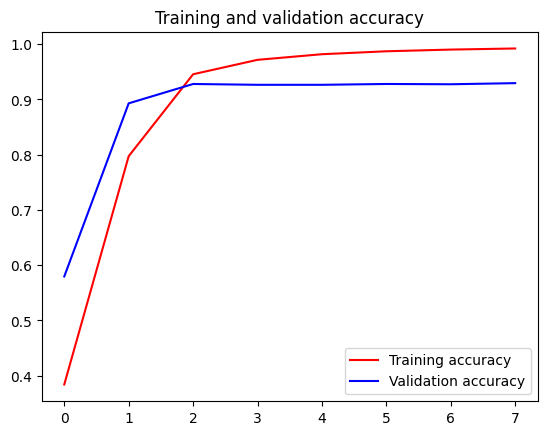

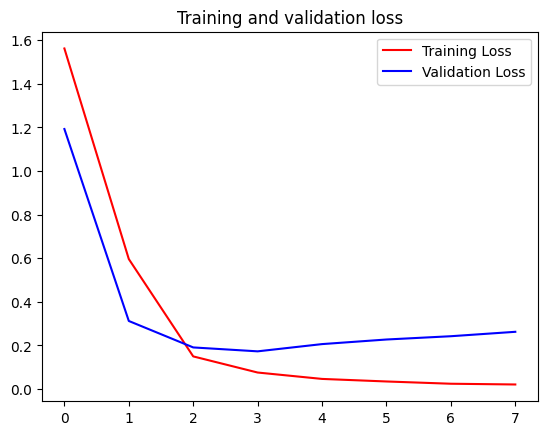

In [23]:
# Visualize Loss & Accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
model.save('../model/emotion-classification.h5')

### Predicting diary input

In [25]:
# Import function for predicting
import function as fc

/workspaces/Machine-Learning/notebooks/function.py:41: SyntaxWarning: invalid escape sequence '\]'
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
/workspaces/Machine-Learning/notebooks/function.py:44: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
mytext = "i sad384y593"

#alt+z to wrap text
mytext2 = "Today was one of those days that filled me with pure joy. The weather was perfect, with clear skies and a gentle breeze that made everything feel fresh and new. I woke up early, feeling energized, and decided to take a walk around the neighborhood. The sunrise painted the sky with soft pinks and oranges, and I couldn’t help but pause and take it all in. There’s something so peaceful about those quiet mornings, just me and the world waking up. Later, I met up with a friend for coffee, and we spent hours laughing and reminiscing. It’s amazing how the simplest conversations can fill you with so much happiness, and I realized that joy isn’t about grand moments—it’s found in the small, everyday things. Whether it’s the feeling of the sun on your skin, the sound of a good friend’s laughter, or the peace that comes from just being present, today reminded me that joy is all around if we take the time to appreciate it. I ended the day feeling grateful for everything I have, from the simple moments to the wonderful people in my life. It was one of those days that will stay with me for a long time, a reminder that happiness doesn’t have to be complicated—it’s right here in front of us"

In [27]:
fc.predicting_input(mytext)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


'The predicted label is: fear'

In [28]:
fc.predicting_input(mytext2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


'The predicted label is: love'